## Классификация видео при помощи 3D нейронной сети

In [ ]:
import sys
import os
import pathlib
import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import random
import collections

import cv2
import einops # для тензонрых преобразоаний
import imageio
import remotezip as rz

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_docs.vis import embed

In [ ]:
def plot_model_metrics(history):
    # разделяем данные из истории обучения на треноровочные и тестовые
    metrics = list(history.history.items())[:len(history.history.items())//2+1]
    val_metrics = list(history.history.items())[len(history.history.items())//2:]

    plt.figure(figsize=(30, 5))

    for i, metric, val_metric in zip(range(len(history.history.keys())), metrics, val_metrics):
        metric_mean = np.mean(metric[1][-3:])
        val_metric_mean = np.mean(val_metric[1][-3:])

        plt.subplot(1, len(history.history.items()), i+1)
        plt.plot(range(1, len(metric[1])+1), metric[1], c='blue', label='training')
        plt.ylim(0, metric_mean + val_metric_mean)
        plt.plot(range(1, len(val_metric[1])+1), val_metric[1], c='red', label='validation')
        plt.legend(loc='upper right')
        plt.title(metric[0].upper())
        plt.xlabel('epochs')
        plt.ylabel(metric[0])
        plt.tight_layout(h_pad=2, w_pad=2)
        plt.grid(True)

## Загрузка исходного датасета

In [ ]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

In [ ]:
def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a URL with the zip file.
      

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [ ]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

In [ ]:
def get_class(fname):
    return fname.split('_')[-3]

In [ ]:
def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 
    Извлекает файлы, принадлежащие к каждому классу

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

In [ ]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 101
Num videos for class[0]: 145


In [ ]:
def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))  # извлекаем файл в нужную папку
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]  # вернет название файла вместе с расширением
      # .parts - возвращает кортеж из частей указанного пути
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)


In [ ]:
def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

In [ ]:
def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
    
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [ ]:
def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)  # словарь с ключом - класс, значением - список из видео класса

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:  # перемешали видео, чтобы не шли подряд
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

In [ ]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir=download_dir)


train :


100%|██████████| 300/300 [05:48<00:00,  1.16s/it]


val :


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


test :


100%|██████████| 100/100 [01:55<00:00,  1.15s/it]


In [ ]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")


Total videos: 500


## Обработка видео

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame


In [ ]:
def frames_from_video_file(video_path, n_frames, output_size = (224, 224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)  # количество кадров видеодорожки

  # длина видео, которую будем обрабатывать
  need_length = 1 + (n_frames - 1) * frame_step  # надо разбить кадры через каждые 15 кадров

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

## Визуализация данных

In [ ]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


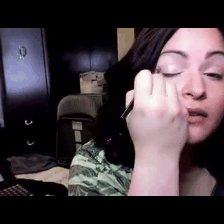

In [ ]:
# docs-infra: no-execute
ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.avi')), 50)
to_gif(ucf_sample_video)

In [ ]:
class FrameGenerator:
  def __init__(self, path, n_frames, training=False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 1


In [ ]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

In [ ]:
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


## Разделение данных

In [ ]:
# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)


In [ ]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (8, 10, 224, 224, 3)
Shape of training labels: (8,)
Shape of validation set of frames: (8, 10, 224, 224, 3)
Shape of validation labels: (8,)


In [ ]:
# Define the dimensions of one frame in the set of frames created
WIDTH, HEIGHT = 224, 224

In [ ]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      Последовательность сверточных слоев, которые сначала применяют операцию свертки к
      пространственным измерениям, а затем к временному измерению.
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Пространственная декомпозиция
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),  # глубина, высота, ширина
                      padding=padding),
        # Временная декомпозиция
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),  # глубина, высота, ширина
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

In [ ]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

In [ ]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [ ]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [ ]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos


In [ ]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [ ]:
frames, label = next(iter(train_ds))
model.build(frames)

In [ ]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])


In [ ]:
history = model.fit(x = train_ds,
                    epochs = 5, # 50
                    validation_data = val_ds)


Epoch 1/50


38/38 [==============================] - 91s 2s/step - loss: 2.5884 - accuracy: 0.0700 - val_loss: 2.2826 - val_accuracy: 0.1600
Epoch 2/50
38/38 [==============================] - 83s 2s/step - loss: 2.2633 - accuracy: 0.1433 - val_loss: 2.3032 - val_accuracy: 0.1800
Epoch 3/50
38/38 [==============================] - 81s 2s/step - loss: 2.1571 - accuracy: 0.2333 - val_loss: 2.2077 - val_accuracy: 0.1400
Epoch 4/50
38/38 [==============================] - 89s 2s/step - loss: 2.0969 - accuracy: 0.2267 - val_loss: 2.1294 - val_accuracy: 0.1800
Epoch 5/50
38/38 [==============================] - 89s 2s/step - loss: 2.0211 - accuracy: 0.2600 - val_loss: 1.9604 - val_accuracy: 0.2700
Epoch 6/50
38/38 [==============================] - 84s 2s/step - loss: 1.9433 - accuracy: 0.2733 - val_loss: 1.9185 - val_accuracy: 0.2500
Epoch 7/50
38/38 [==============================] - 86s 2s/step - loss: 1.8518 - accuracy: 0.3133 - val_loss: 2.1189 - val_accuracy: 0.2600
Epoch 8/50
38/38 [

In [ ]:
m = tf.keras.models.load_model('video_prep_time_way_model.keras')

TypeError: Cannot deserialize object of type `Conv2Plus1D`. If `Conv2Plus1D` is a custom class, please register it using the `@keras.saving.register_keras_serializable()` decorator.

## Обработка результата

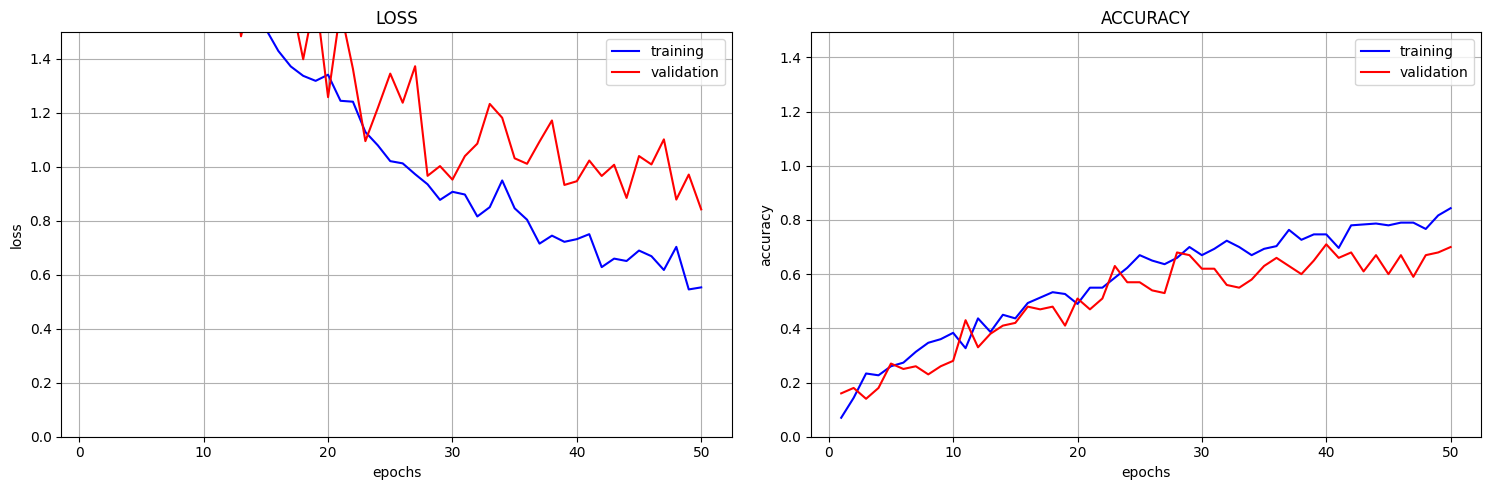

In [ ]:
plot_model_metrics(history)

In [ ]:
model.evaluate(test_ds, return_dict=True)

13/13 [==============================] - 9s 659ms/step - loss: 0.9903 - accuracy: 0.7200


{'loss': 0.9903228878974915, 'accuracy': 0.7200000286102295}

In [ ]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  # потестить
  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [ ]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

38/38 [==============================] - 25s 656ms/step


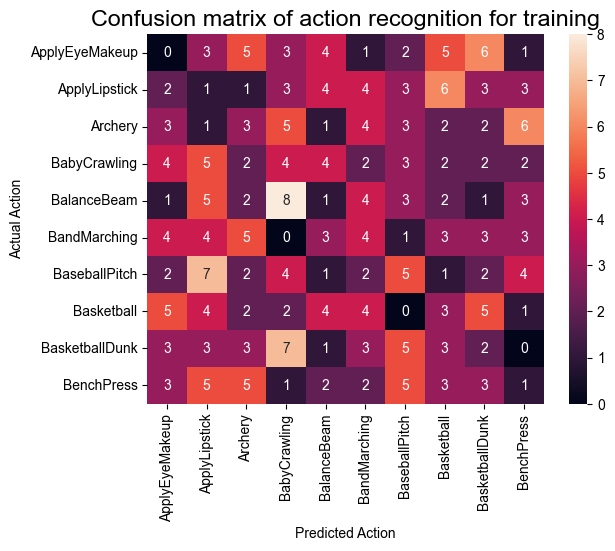

In [ ]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

13/13 [==============================] - 8s 622ms/step


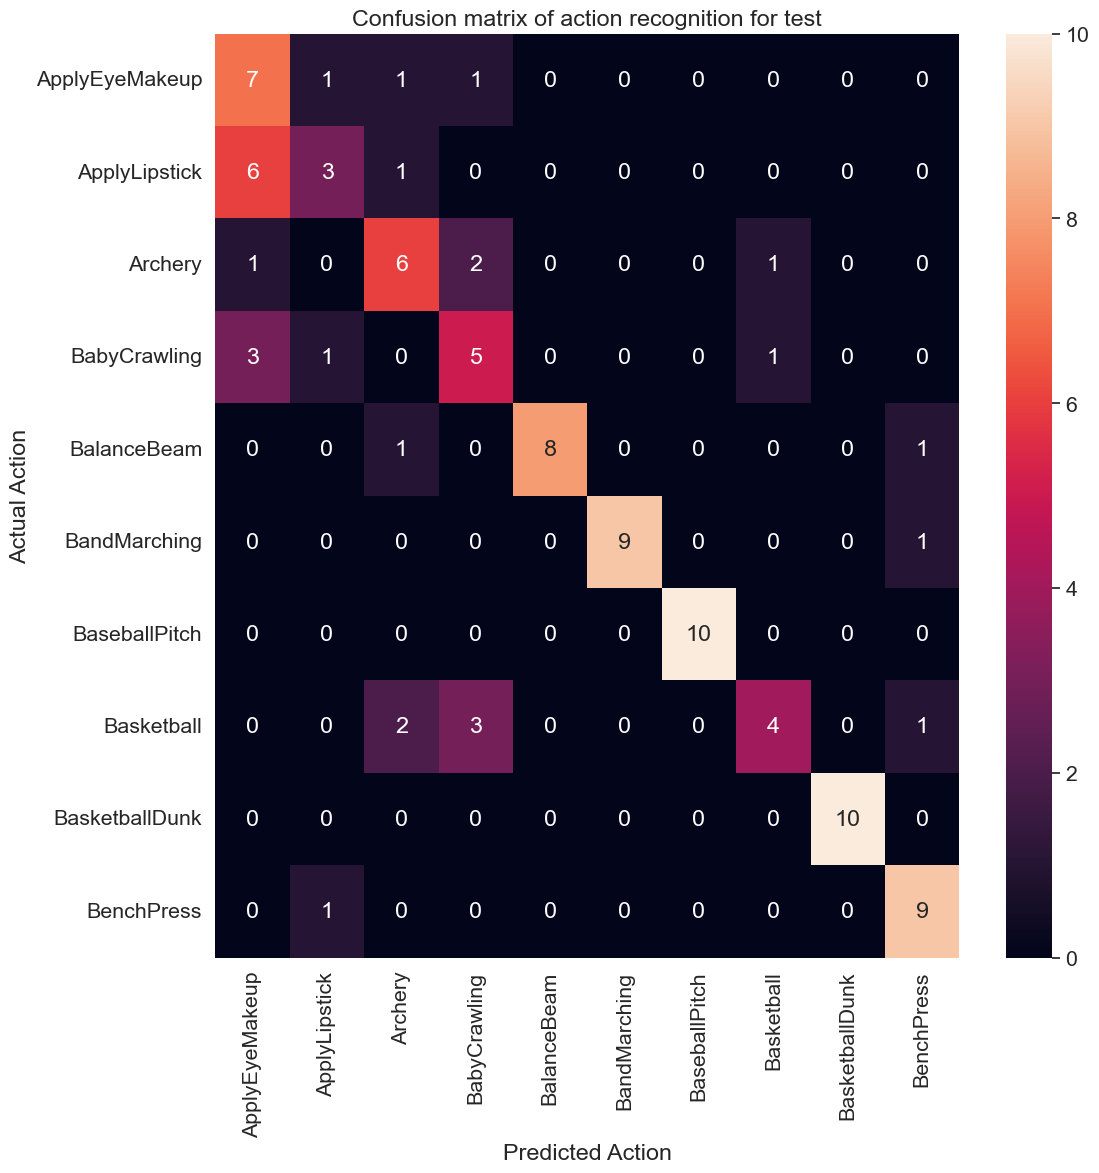

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall


In [ ]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [ ]:
precision

{'ApplyEyeMakeup': 0.4117647058823529,
 'ApplyLipstick': 0.5,
 'Archery': 0.5454545454545454,
 'BabyCrawling': 0.45454545454545453,
 'BalanceBeam': 1.0,
 'BandMarching': 1.0,
 'BaseballPitch': 1.0,
 'Basketball': 0.6666666666666666,
 'BasketballDunk': 1.0,
 'BenchPress': 0.75}

In [ ]:
recall

{'ApplyEyeMakeup': 0.7,
 'ApplyLipstick': 0.3,
 'Archery': 0.6,
 'BabyCrawling': 0.5,
 'BalanceBeam': 0.8,
 'BandMarching': 0.9,
 'BaseballPitch': 1.0,
 'Basketball': 0.4,
 'BasketballDunk': 1.0,
 'BenchPress': 0.9}